In [1]:
import pandas
import numpy

import seaborn
from matplotlib import pyplot as plt

In [2]:


def load_dataset(path):

    df = pandas.read_csv(path)
    
    return df

   
path = './dataset/cards-cleaned-1.csv'
data = load_dataset(path)
data.head()

,filename,tick,r,g,b,button,section,label
0,cards-2hz-100ms-2.csv,36000,84.0,37.0,193.0,0.0,NaN,ambient
1,cards-2hz-100ms-2.csv,36500,83.0,36.0,192.0,0.0,NaN,ambient
2,cards-2hz-100ms-2.csv,37000,84.0,36.0,193.0,0.0,NaN,ambient
3,cards-2hz-100ms-2.csv,37500,83.0,35.0,191.0,0.0,NaN,ambient
4,cards-2hz-100ms-2.csv,38000,84.0,36.0,192.0,0.0,NaN,ambient


In [3]:
data.label.value_counts()

ambient      187
Purple        30
Black         29
Pink          29
Blue          29
Grey          28
Red           28
DarkBlue      28
PaleGreen     27
White         26
Yellow        25
Name: label, dtype: int64

In [52]:

def undersample_class(data, label='ambient', random_state=1, target = 30):
    
    data = data.copy() # avoid mutating input
    is_target = data['label'] == label
    sampled = data[is_target].sample(n=target, random_state=random_state)
    out = pandas.concat([ data[~is_target], sampled ])
    return out

cleaned = undersample_class(data)
cleaned = cleaned.dropna(subset=['label', 'section'])
cleaned.label.value_counts()

Purple       30
Black        29
Pink         29
Blue         29
Grey         28
Red          28
DarkBlue     28
PaleGreen    27
White        26
Yellow       25
Name: label, dtype: int64

In [125]:
import skimage.color

def convert_from_rgb(X, target='hsv'):

    X = numpy.array(X)
    func_name = f'rgb2{target}'
    func = getattr(skimage.color, func_name)
    conv = func(X)
    return conv

def convert_to_rgb(X, target='hsv'):

    X = numpy.array(X)
    func_name = f'{target}2rgb'
    func = getattr(skimage.color, func_name)
    conv = func(X)
    return conv

def make_color_transformer(target) -> sklearn.base.TransformerMixin:
    """
    sklearn Transformer for converting RGB colors (in individual columns) to other color spaces (and back)
    """
    from sklearn.preprocessing import FunctionTransformer

    def feature_namer(self, input_features):
        t = target
        if len(target) == 3:
            # yuv,hsv et.c.
            output_features = ( t[0], t[1], t[2] )
        elif len(target) == 5:
            # YCbCr,YPbPr et.c.
            output_features = ( t[0], t[1:3], t[3:5] )
        else:
            raise ValueError(f"Cannot compute features for target {target}")
        return output_features
    
    t = FunctionTransformer(func=convert_from_rgb,
                            inverse_func=convert_to_rgb,
                            kw_args=dict(target=target),
                            inv_kw_args=dict(target=target),
                           feature_names_out=feature_namer)
    return t


make_color_transformer(target='lab').set_output(transform="pandas").fit_transform(MinMaxScaler().fit_transform(data[['r', 'g', 'b']]))[0:5]


,l,a,b
0,7.661988,21.529613,6.320386
1,7.631299,21.417366,6.907319
2,7.631299,21.417366,6.907319
3,8.017054,22.065504,7.915974
4,7.631299,21.417366,6.907319


In [136]:

def transform_color(data, transform):
    columns = ['r', 'g', 'b']
    y = data['label']
    rgb = MinMaxScaler().fit_transform(data[columns])

    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.decomposition import PCA
    
    t = None
    if transform == 'pca':
        t = PCA(3)
    elif transform == 'lda':
        t = LinearDiscriminantAnalysis(n_components=3)
    else:
        t =  make_color_transformer(target=transform)
    
    t.set_output(transform="pandas")
    out = t.fit_transform(rgb, y)
    return out


transforms = [
    'pca',
    'lda',
    'hsv',
    'ycbcr',
    'lab',
]

enriched = data.copy()
for name in transforms:
    t = transform_color(data, transform=name)
    enriched = pandas.merge(enriched, t.add_prefix(f'{name}_'), right_index=True, left_index=True)

enriched



,index,filename,tick,r,g,b,button,section,label,split,...,lda_lineardiscriminantanalysis2,hsv_h,hsv_s,hsv_v,ycbcr_y,ycbcr_cb,ycbcr_cr,lab_l,lab_a,lab_b
0,11,cards-2hz-100ms-2.csv,41500,90.0,98.0,248.0,1.0,0.0,Black,train,...,-6.039251,0.975947,0.851244,0.193103,33.646738,124.443890,145.978274,7.661988,21.529613,6.320386
1,12,cards-2hz-100ms-2.csv,42000,90.0,98.0,245.0,1.0,0.0,Black,train,...,-5.991007,0.981265,0.851244,0.193103,33.515797,123.856478,146.073802,7.631299,21.417366,6.907319
2,13,cards-2hz-100ms-2.csv,42500,90.0,98.0,245.0,1.0,0.0,Black,train,...,-5.991007,0.981265,0.851244,0.193103,33.515797,123.856478,146.073802,7.631299,21.417366,6.907319
3,14,cards-2hz-100ms-2.csv,43000,91.0,98.0,243.0,1.0,0.0,Black,train,...,-5.832397,0.985422,0.856373,0.200000,33.880097,123.204200,146.909901,8.017054,22.065504,7.915974
4,15,cards-2hz-100ms-2.csv,43500,90.0,98.0,245.0,1.0,0.0,Black,train,...,-5.991007,0.981265,0.851244,0.193103,33.515797,123.856478,146.073802,7.631299,21.417366,6.907319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,718,cards-2hz-100ms-4.csv,214000,66.0,588.0,332.0,1.0,9.0,DarkBlue,train,...,3.676499,0.365824,0.969633,0.908438,139.564552,81.870173,42.260820,80.625722,-78.195102,68.839316
275,719,cards-2hz-100ms-4.csv,214500,67.0,594.0,329.0,1.0,9.0,DarkBlue,train,...,4.023860,0.363394,0.962487,0.919210,141.269976,80.222777,42.118500,81.484731,-78.970625,70.044841
276,720,cards-2hz-100ms-4.csv,215000,66.0,591.0,330.0,1.0,9.0,DarkBlue,train,...,3.794996,0.364969,0.969812,0.913824,140.169644,81.078908,41.819374,81.051234,-78.625588,69.503855
277,721,cards-2hz-100ms-4.csv,215500,67.0,596.0,327.0,1.0,9.0,DarkBlue,train,...,4.113579,0.362617,0.962632,0.922801,141.644273,79.564731,41.845431,81.766602,-79.272738,70.561072


In [178]:
card_data_order = [
    'Black',
    'White',
    'Grey', # cardboard
    'Pink',
    'Yellow',
    'Red',
    'PaleGreen',
    'Purple',
    'Blue',
    'DarkBlue',
]
def make_label_mapping(section_labels):

    label_mapping = {
        #numpy.nan: 'ambient'
    }
    for idx, label in enumerate(section_labels):
        label_mapping[idx] = label
    return label_mapping

label_mapping = make_label_mapping(card_data_order)
label_mapping

cards_color_map = dict(zip(label_mapping.values(), label_mapping.values()))
cards_color_map.update({
    'ambient': 'Sienna',
    'White': 'Beige', 
})
cards_color_map


{'Black': 'Black',
 'White': 'Beige',
 'Grey': 'Grey',
 'Pink': 'Pink',
 'Yellow': 'Yellow',
 'Red': 'Red',
 'PaleGreen': 'PaleGreen',
 'Purple': 'Purple',
 'Blue': 'Blue',
 'DarkBlue': 'DarkBlue',
 'ambient': 'Sienna'}

In [190]:

import plotly.subplots

spacing = 0.01 * 5
fig = plotly.subplots.make_subplots(rows=len(transforms), cols=3,
        vertical_spacing=spacing,
        horizontal_spacing=spacing,
        row_titles=transforms,
)
for row, name in enumerate(transforms):

    cols = [ c for c in enriched.columns if c.startswith(f'{name}_') ]
    #cols = [ c.replace('lda_lineardiscriminantanalysis', 'lda_') for c in cols ]
    combinations = list(itertools.combinations(cols, 2))
    
    
    for col, (x_col, y_col) in enumerate(combinations):

        e = plotly.express.scatter(enriched, y=y_col, x=x_col, color='label', color_discrete_map=cards_color_map)
        for trace in range(len(e["data"])):
            t = e["data"][trace]
            t['showlegend'] = False
            fig.append_trace(t, row=row+1, col=col+1)

            fig.update_xaxes(title_text=x_col, title_standoff = 5, row=row+1, col=col+1)
            fig.update_yaxes(title_text=y_col, title_standoff = 3, row=row+1, col=col+1)
        

    
fig.update_layout(height=1200, width=1200, template='plotly')
fig

In [ ]:
# LDA does super nicely
# PCA also pretty good
# YCbCr, cr-y best non-trained ?

# LAB a-b and CbCr white/black collapses

# HSV h is circular / wraps around. So black/white are at both ends


In [61]:
from sklearn.model_selection import GroupShuffleSplit

def test_split_grouped(df, group, test_size=0.20, random_state=3):
    df = df.reset_index() # use numerical index
    groups = df[group]

    out = df.copy()
    
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for i, (train_index, test_index) in enumerate(gss.split(df, groups=groups)):

        out.loc[train_index, 'split'] = 'train'
        out.loc[test_index, 'split'] = 'test'
    
    return out

data = test_split_grouped(cleaned, group='filename')
data.split.value_counts()


train    211
test      68
Name: split, dtype: int64

In [62]:
data[data.split == 'train'].label.value_counts()

Purple       23
Black        22
Grey         22
Pink         22
Blue         22
Red          21
DarkBlue     21
White        20
Yellow       19
PaleGreen    19
Name: label, dtype: int64

In [256]:

def evaluate_model(data, est,
                   features = ['r', 'g', 'b'],
                   group='filename',
                   scorer='accuracy',
                   random_state=3,
                   folds=10,
                   label = 'label',
                   val_size=0.2):

    
    
    X = data[features]
    Y = data[label]
    groups = data[group]

    splitter = sklearn.model_selection.GroupShuffleSplit(n_splits=folds, test_size=val_size, random_state=random_state)
    scores = cross_val_score(est, X=X, y=Y, scoring=scorer, error_score='raise', cv=splitter, groups=groups)

    res = pandas.DataFrame({
        scorer: scores,
        'fold': numpy.arange(len(scores)),
    })
    
    return res

def evaluate_models(data, models):

    dfs = []
    for name, estimator in models.items():
        
        res = evaluate_model(data, estimator)
        res['model'] = name
        
        dfs.append(res)

    df = pandas.concat(dfs, ignore_index=True)
    return df

def make_column_selector(columns):
    def select(X):
        return X[columns]
        
    t = FunctionTransformer(select)
    return t

from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

import sklearn.pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

MODELS = {
    'pca2-centroid': sklearn.pipeline.make_pipeline(
        PCA(2),
        NearestCentroid(),
    ),

    'pca2-knn': sklearn.pipeline.make_pipeline(
        PCA(2),
        KNeighborsClassifier(n_neighbors=1),
    ),
    
    'rgb-randomforest': sklearn.pipeline.make_pipeline(
        RandomForestClassifier(n_estimators=10, min_samples_leaf=0.01, max_depth=5)
    ),

    'CrY-centroid': sklearn.pipeline.make_pipeline(
        MinMaxScaler(),
        make_color_transformer(target='ycbcr').set_output(transform="pandas"),
        make_column_selector(columns=['cr', 'y']),
        NearestCentroid(),
    ),

    'CrY-randomforest': sklearn.pipeline.make_pipeline(
        MinMaxScaler(),
        make_color_transformer(target='ycbcr').set_output(transform="pandas"),
        make_column_selector(columns=['cr', 'y']),
        RandomForestClassifier(n_estimators=100, min_samples_leaf=0.01, max_depth=10)
    ),

    'CrY-GMM': sklearn.pipeline.make_pipeline(
        MinMaxScaler(),
        make_color_transformer(target='ycbcr').set_output(transform="pandas"),
        make_column_selector(columns=['cr', 'y']),
        GaussianMixtureClassifier()
    ),
}

train_data = data[data.split == 'train']
results = evaluate_models(train_data, MODELS)

def plot_results(results):

    import plotly.express

    fig = plotly.express.strip(results, y='accuracy', x='model', height=400, width=600)

    fig.update_yaxes(visible=True, range=(0.0, 1.1))
    
    return fig

plot_results(results)


In [255]:

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MaximumProbabilityClassifier(BaseEstimator, ClassifierMixin):
    """
    Allows using clustering-type models that implement score_samples as a classifier.
    One based estimator is fitted per-class.

    Compatible with scikit-learn, including use in Pipeline
    """
    
    def __init__(self, base):
        self.base = base
    
    def fit(self, X, y, **kwargs):
        X, y = check_X_y(X, y)

        from sklearn.utils.multiclass import unique_labels
        self.classes_ = unique_labels(y)

        self.estimators_ = []
        
        for label in self.classes_:
            class_X = X[y == label]
            class_Y = y[y == label]
            #print(label, class_X.shape, class_Y.shape)
            est = sklearn.base.clone(self.base)
            est.fit(class_X, class_Y, **kwargs)
            self.estimators_.append(est)

        return self

    def predict(self, X, **kwargs):
        D = self.predict_proba(X, **kwargs)        
        preds = self.classes_[numpy.argmax(D, axis=1)]
        assert len(preds) == len(X)
        return preds

    def predict_proba(self, X, **kwargs):
        check_is_fitted(self)
        
        X = check_array(X)
        
        # call each of the models, get probabilities
        probs = []
        for est in self.estimators_:
            #print(est.means_)
            p = est.score_samples(X, **kwargs)
            #print(numpy.min(p), numpy.max(p))
            probs.append(p)

        proba = numpy.vstack(probs).T
        assert len(proba) == len(X), proba.shape
        assert proba.shape[1] == len(self.classes_), proba.shape
        return proba
        
    def fit_predict(self, X, y, **kwargs):
        self.fit(X, y, **kwargs)        
        return self.predict(X, **kwargs)

class GaussianMixtureClassifier(MaximumProbabilityClassifier):
    """
    Classifier using Gaussian Mixture Models (GMM)
    """
    def __init__(self, **kwargs):
        from sklearn.mixture import GaussianMixture
        base = GaussianMixture(**kwargs)
        super().__init__(base=base)


GaussianMixtureClassifier(n_components=1).fit_predict(enriched[['ycbcr_cr', 'ycbcr_y']], enriched['label'])[0:10]


array(['Black', 'Black', 'Black', 'Black', 'Black', 'White', 'White',
       'White', 'White', 'White'], dtype='<U9')

<AxesSubplot: xlabel='pca.1', ylabel='pca.2'>

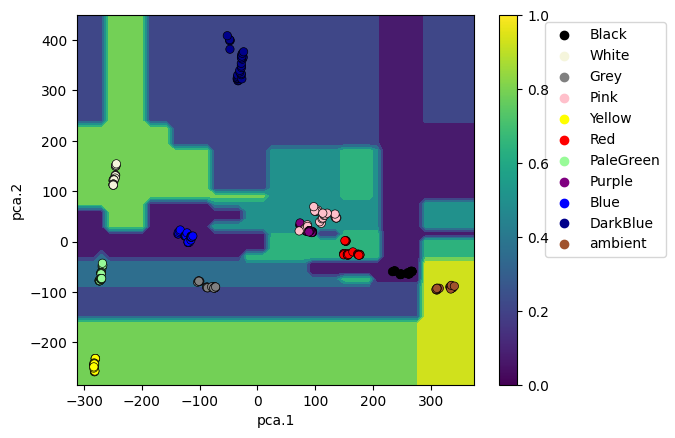

In [227]:

# FIXME: plot the decision boundaries of the various models

# Plot decision boundaries, in PCA 2d space

def pca_transform_2d(data, columns = ['r', 'g', 'b']):
    from sklearn.decomposition import PCA
  
    pca = PCA(2)
    data = data.dropna(subset=columns)
    
    X = data[columns]
    dd = pca.fit_transform(X)
    df = pandas.DataFrame(dd, columns=['pca.1', 'pca.2'], index=data.index)
    return df, pca

def plot_decision_surface(estimator, data,
                          x_steps=50, y_steps=50,
                         response_method="predict"):

    from sklearn.inspection import DecisionBoundaryDisplay
    from sklearn.preprocessing import LabelEncoder
    
    # Transform to 2d using PCA
    pca_data, pca = pca_transform_2d(data)
    pca1, pca2 = pca_data['pca.1'], pca_data['pca.2']
    
    feature_1, feature_2 = numpy.meshgrid(
        numpy.linspace(pca1.min() * 1.1, pca1.max() * 1.1, num=x_steps),
        numpy.linspace(pca2.min() * 1.1, pca2.max() * 1.1, num=y_steps)
    )
    pca_grid = numpy.vstack([feature_1.ravel(), feature_2.ravel()]).T

    # Make predictions in RGB space,
    rgb_grid = pandas.DataFrame(pca.inverse_transform(pca_grid), columns=['r', 'g', 'b'])
    
    if response_method == 'decision_function':
        y_pred = estimator.decision_function(rgb_grid)
    elif response_method == 'score_samples':
        y_pred = estimator.score_samples(rgb_grid)
    elif response_method == 'negative_outlier_factor_':
        y_pred = estimator.negative_outlier_factor_
    elif response_method == 'predict':
        # DecisionBoundaryDisplay breaks with string labels, convert to numerical
        le = LabelEncoder()
        y_pred = le.fit_transform(estimator.predict(rgb_grid))
    else:
        raise ValueError()
    y_pred = numpy.reshape(y_pred, feature_1.shape)

    #print(y_pred)
    
    display = DecisionBoundaryDisplay(
        xx0=feature_1,
        xx1=feature_2,
        response=y_pred
    )
    display.plot()

    ax = display.ax_
    # Show datapoints
    seaborn.scatterplot(ax=ax,
        x=pca1,
        y=pca2,
        hue=data['label'].values.astype(str),
        edgecolor="black",
        palette=cards_color_map,
    )
    ax.legend(bbox_to_anchor=(1.5, 1.00))
    
    plt.colorbar(ax.collections[1])
    
    return ax

plot_decision_surface(est, cleaned)

In [228]:
# TODO: use emlearn to convert, write C code output

<AxesSubplot: xlabel='pca.1', ylabel='pca.2'>

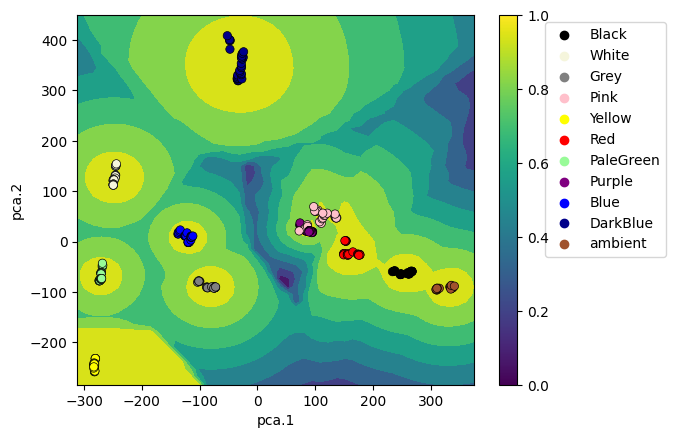

In [229]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
import sklearn.pipeline  

detector = sklearn.pipeline.make_pipeline(
        PCA(2),
        LocalOutlierFactor(n_neighbors=25, novelty=True),
)
    
#detector = LocalOutlierFactor(n_neighbors=2, novelty=True)
#detector.fit(cleaned[cleaned.label == 'Pink'][features])
detector.fit(cleaned[features])
plot_decision_surface(detector, cleaned, response_method="score_samples")

<AxesSubplot: xlabel='pca.1', ylabel='pca.2'>

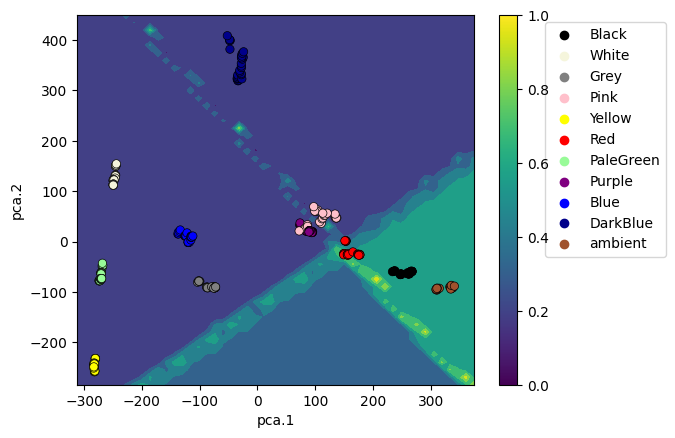

In [230]:
from sklearn.ensemble import IsolationForest

detector = sklearn.pipeline.make_pipeline(
        PCA(2),
        IsolationForest(n_estimators=100, contamination=0.1),
)

#detector = IsolationForest(n_estimators=100, contamination=0.001)
detector.fit(cleaned[cleaned.label == 'Red'][features])

plot_decision_surface(detector, cleaned, response_method="score_samples")